**Binary Classifier**

In [1]:
from sklearn import datasets

# Load dataset
iris = datasets.load_iris()

print("Type:", type(iris))  # sklearn.utils.Bunch

Type: <class 'sklearn.utils.Bunch'>


In [3]:
# Inspect object
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [4]:
# Get feature names
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [6]:
import pandas as pd

# Category distribution
pd.value_counts(iris["target"])

0    50
1    50
2    50
dtype: int64

In [7]:
# Categories
print("Target names:", iris.target_names)

Target names: ['setosa' 'versicolor' 'virginica']


Create binary classifier recognises setosa. Need target vector y that returns 1 for setosa and 0 for other two

In [8]:
# Create the binary target vector
y = (iris["target"] == 0).astype(int)

In this code, we create an array of boolean values where True denotes the positive class and False the negative one. We then convert the boolean values into zeros and ones using the astype(int) function.

In [16]:
# Create the input matrix
X = iris["data"]  # Get matrix with all features
X = X[:, [2, 3]]  # Keep only petal features

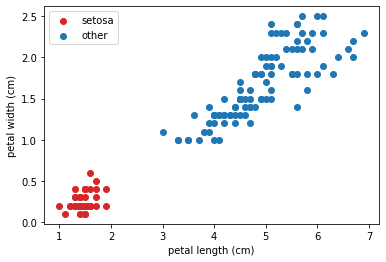

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot data points
setosa_idx = y == 1  # setosa data points

plt.scatter(
    X[:, 0][setosa_idx], X[:, 1][setosa_idx], color="C3", label="setosa"
)  # Setosa
plt.scatter(
    X[:, 0][~setosa_idx], X[:, 1][~setosa_idx], color="C0", label="other"
)  # Versicolor and virginica

# Set labels
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.legend()
plt.show()

In this case, we say that the data is linearly separable because it’s possible to draw a line (or a hyperplane in higher dimensions) that separates the different categories.

In [19]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

To avoid any issue with the features scale, let’s encapsulate the estimator in a pipeline with a StandardScaler

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create the estimator
logreg = make_pipeline(StandardScaler(), LogisticRegression())

# Fit it to train data
logreg.fit(X_tr, y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

The LogisticRegression documentation recommends using the liblinear solver for small datasets.

In [21]:
# Create the estimator
logreg = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))

# Fit it to train data
logreg.fit(X_tr, y_tr)

# Accuracy on test set
accuracy = logreg.score(X_te, y_te)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 1.000


We obtain a test accuracy of 1 which means that our estimator correctly classified all points from the test set. We can compute predictions for new data points with the predict() function

In [22]:
# New flower
new_flower = [
    1.5,  # petal length (cm)
    0.3,  # petal width (cm)
]

# Classify it
logreg.predict([new_flower])

array([1])

Our classifier labels the new data point with a one (positive class) which means that it’s likely a setosa flower. We can obtain the probabilities from the sigmoid with predict_proba()

In [23]:
# Get probabilities
logreg.predict_proba([new_flower])

array([[0.05238258, 0.94761742]])

According to our classifier, the new data point is a setosa flower with probability 0.95.

Note that we can use this function to visualize the decision surface of our classifier and draw the boundary that delimits the two classes by marking points with p=0.5. In short, the function creates a grid of data points in the range of our X/y values and evaluates their probability using our logreg estimator.

In [25]:
import numpy as np

# Helper function
def decision_surface(ax, X, y, logreg):
    # Plot data points
    setosa_idx = y == 1  # Setosa data points

    plt.scatter(
        X[:, 0][setosa_idx], X[:, 1][setosa_idx], color="C3", label="setosa"
    )  # Setosa
    plt.scatter(
        X[:, 0][~setosa_idx], X[:, 1][~setosa_idx], color="C0", label="other"
    )  # Versicolor and virginica

    # Create a grid of values
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    x_values = np.linspace(*xlim, num=40)
    y_values = np.linspace(*ylim, num=40)
    xx, yy = np.meshgrid(x_values, y_values)
    points = np.c_[xx.flatten(), yy.flatten()]

    # Probability for positive class (setosa)
    probs = logreg.predict_proba(points)
    prob_setosa = probs[:, 1]

    # Draw decision boundary (p=0.5)
    zz = prob_setosa.reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=[0.5], colors="gray")

    # Plot decision surface with level curves
    plt.contourf(xx, yy, zz, 10, alpha=0.3, cmap=plt.cm.coolwarm)

    # Add labels
    plt.xlabel("petal length (cm)")
    plt.ylabel("petal width (cm)")
    plt.legend()
    plt.colorbar(label="probability")
    plt.show()

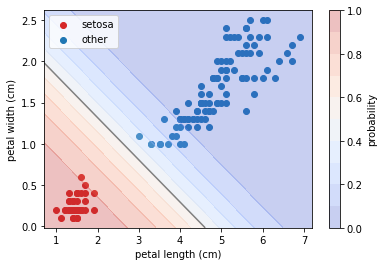

In [26]:
# Plot decision surface
fig = plt.figure()
decision_surface(fig.gca(), X, y, logreg)

We use a red/blue scale to plot the decision surface. Regions in red are associated with probabilities close to one and regions in blue with probabilities close to zero. The gray line delimits points with p<0.5 from points with p>0.5.

**Multiclass Classification**

In this unit, we will discuss two different ways to apply logistic regressions to the multiclass case.

1. Using softmax regression which directly generalizes logistic regressions to multiple classes.
2. Using the one-vs.-one (OvO) and the one-vs.-rest (OvR) strategies that convert the multiclass classification problem into several binary classifications.

Note that the second option is not specific to logistic regressions and can use any set of binary classifiers to solve a multiclass classification problem.

it’s common to try both the one-vs.-rest (OvR) strategy and softmax regression, and see which one gives the best results.

In [27]:
# Create X/y arrays
X = iris['data'][:, [2, 3]] # Keep only petal features
y = iris['target']

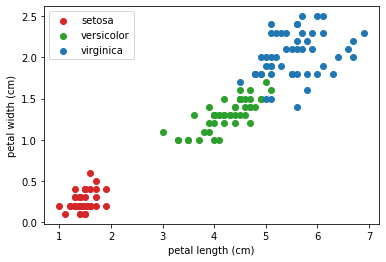

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot data
setosa_idx = (y == 0) # Setosa points
versicolor_idx = (y == 1) # Versicolor points
virginica_idx = (y==2) # Virginica points

plt.scatter(X[:, 0][setosa_idx], X[:, 1][setosa_idx], c='C3', label='setosa')
plt.scatter(X[:, 0][versicolor_idx], X[:, 1][versicolor_idx], c='C2', label='versicolor')
plt.scatter(X[:, 0][virginica_idx], X[:, 1][virginica_idx], c='C0', label='virginica')

# Set labels
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.legend()
plt.show()

In [29]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=0)

*Multiclass logistic regression with OvR*

By default, the LogisticRegression estimator uses the one-vs.-rest (OvR) strategy for multiclass classification in all Scikit-learn versions prior to version 0.22. The later versions use softmax regression by default.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create the estimator
logreg = make_pipeline(
    StandardScaler(), LogisticRegression(multi_class='ovr', solver='liblinear'))

# Fit it to train data
logreg.fit(X_tr, y_tr)

# Accuracy on test set
accuracy = logreg.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.800


In this code, we create the classifier, fit it to the train data and evaluate it on the test set. We get an accuracy around 80%. We can see on the plot from above that each category occupies a different region. The separation between versicolor and virginica flowers is not entirely clear, but we should be able to create a classifier with an accuracy close to 100%.

The issue comes from the regularization term. By default, Scikit-learn adds an 
L
2
 term to the loss function of the logistic model. In our case, the regularization strength is too large and our model is underfitting. It’s not possible to remove this regularization term from the LogisticRegression object, but we can reduce its impact with the C parameter which is the inverse of the regularization strength.



In [31]:
# Create the estimator
logreg = make_pipeline(
    # C: inverse of regularization strength
    StandardScaler(), LogisticRegression(C=1000, multi_class='ovr', solver='liblinear'))

# Fit it to train data
logreg.fit(X_tr, y_tr)

# Accuracy on test set
accuracy = logreg.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.978


 In the code from above, we set it to a thousand which means that the penalization term has a small impact on the overall loss value, and we get an accuracy around 98%.

Predict new data points

In [32]:
# New flower
new_flower = [
    5, # petal length (cm)
    1.5, # petal width (cm)
]

# Predict probabilities
logreg.predict_proba([new_flower])

array([[8.62023737e-08, 5.51329272e-01, 4.48670642e-01]])

In the OvR strategy, there is a classifier for each class that estimates the probability that new data points belongs to it. In this code, the predict_proba() function returns these probabilities normalized such that they sum to one. For instance, if our three classifiers return p1=0.5, p2=0.5 and p3=1, then the function will return [0.25, 0.25, 0.5].

In our example, the second category has the largest probability with p=0.55 and the point is classified as a versicolor iris flower. We can verify that using the predict() function

In [33]:
# Predict class with highest probability
logreg.predict([new_flower])

array([1])

*Softmax Regression*

In [35]:
# Create the estimator
logreg = make_pipeline(
    StandardScaler(), LogisticRegression(multi_class='multinomial', solver='liblinear'))

# Fit it to train data
try:
    logreg.fit(X_tr, y_tr)
except Exception as e:
    print(e) # Solver liblinear does not support a multinomial backend.

Solver liblinear does not support a multinomial backend.


use solver saga (Stochastic Average Gradient descent) supports both OVR and multinomial classification.

In [36]:
# Create the estimator
logreg = make_pipeline(
    StandardScaler(), LogisticRegression(multi_class='multinomial', solver='saga'))

# Fit it to train data
logreg.fit(X_tr, y_tr)

# Accuracy on test set
accuracy = logreg.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy)) # Prints: 0.956

Accuracy: 0.956


Accuracy slightly lower than OvR

Aim to increase accuracy by introducing C

In [37]:
# Create the estimator
logreg = make_pipeline(
    StandardScaler(), LogisticRegression(C=10, multi_class='multinomial', solver='saga'))

# Fit it to train data
logreg.fit(X_tr, y_tr)

# Accuracy on test set
accuracy = logreg.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.978


**Cross Validation**

Scikit-learn implements several cross-validator objects that we can use to perform cross-validation. The KFold one implements the k-fold strategy. We can set the number of folds with the n_splits attribute.

In [39]:
# Create X/y arrays
X = iris["data"]
y = iris["target"]

from sklearn.model_selection import KFold

# Create k-fold object
kfold = KFold(n_splits=3)

Evaluate the generalization performance of a LogisticRegression() estimator with the one-vs.-rest (OvR) multiclass strategy.

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a logistic regression
logreg = make_pipeline(
    StandardScaler(), LogisticRegression(C=1000, solver="liblinear", multi_class="ovr")
)

Apply cross validation

In [41]:
from sklearn.model_selection import cross_validate

# Apply cross-validation
scores = cross_validate(logreg, X, y, cv=kfold, return_train_score=True)

# The "scores" variable is a dictionary with the scores
scores.keys()

dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])

The function takes the estimator, the X/y data and our cross-validator object as arguments, and returns a dictionary with the results. Each entry is a list with one value for each fold.

* fit_time - time to fit the estimator
* score_time - time to evaluate the estimator
* train_score - performance on the (k−1) parts to train the estimator
* test_score - performance on the remaining “validation set”


In [42]:
print("Train scores:", scores["train_score"])
print("Test scores:", scores["test_score"])

Train scores: [0.98 1.   1.  ]
Test scores: [0. 0. 0.]


We can see that the train scores (accuracy) are close to one, but the test scores are all zero. By default, the KFold object splits the data into k parts without shuffling. This can cause issues when the target values are ordered.

The KFold object provides a shuffle parameter to shuffle the data before splitting it into k parts. Note that we can set the seed number with the random_state attribute

In [43]:
# Create k-fold object
kfold = KFold(n_splits=3, shuffle=True, random_state=0)

In [44]:
# Apply cross-validation
scores = cross_validate(logreg, X, y, cv=kfold, return_train_score=True)

print("Train scores:", scores["train_score"])
print("Test scores:", scores["test_score"])

Train scores: [0.98 0.96 0.98]
Test scores: [0.98 0.96 0.96]


Note that we can also pass an integer value to the cv attribute. In this case, the cross_validate() function automatically creates a k-fold cross-validator object and sets its k value

In [45]:
# Apply cross-validation
scores = cross_validate(logreg, X, y, cv=3, return_train_score=True)

print("Train scores:", scores["train_score"])
print("Test scores:", scores["test_score"])

Train scores: [0.95 0.97 0.99]
Test scores: [0.98 0.94 0.94]


By default, it uses a variant of k-fold called stratified k-fold for classification tasks. This strategy ensures that none of the k parts has a category that is under- or over-represented. Hence, we get slightly different accuracy scores in the code from above.

The most commonly used variants are 3, 5 or 10-fold cross-validations. Let’s use the 10-fold one to get a final generalization error estimate for our iris classifier.

In [46]:
import numpy as np

# Apply cross-validation
scores = cross_validate(logreg, X, y, cv=10, return_train_score=True)

# Get train/test scores
train_scores = scores["train_score"]
test_scores = scores["test_score"]

# Print summary
print(
    "Train mean: {:.3f} std: {:.3f}".format(np.mean(train_scores), np.std(train_scores))
)

print("Test mean: {:.3f} std: {:.3f}".format(np.mean(test_scores), np.std(test_scores)))

Train mean: 0.975 std: 0.008
Test mean: 0.960 std: 0.061


*Shuffle Split Strategy*

In [47]:
from sklearn.model_selection import ShuffleSplit

# Try "shuffle split" strategy
cv_type = ShuffleSplit(n_splits=10, test_size=20, random_state=0)

# Apply cross-validation
scores = cross_validate(logreg, X, y, cv=cv_type, return_train_score=True)

# Test scores
test_scores = scores["test_score"]
print("Test mean: {:.3f} std: {:.3f}".format(np.mean(test_scores), np.std(test_scores)))

Test mean: 0.955 std: 0.052


**Grid Search with Cross Validation**

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create pipeline
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(multi_class="ovr", solver="liblinear")),
    ]
)

Instead of splitting the data into a single train/validation pair to estimate the generalization error of the different hyperparameter combinations, we can use cross-validation which has two advantages

* It returns better estimates since we perform evaluation several times
* All the training data is being used i.e. validation data is reused as training data across different folds

It’s important to note that cross-validation is also more computationally costly, we perform the fit/eval loop several times. For this reason, we typically keep the simple train/valid/test set strategy for computationally costly models when we have enough data.

In [49]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Create cross-validation object
grid = {"logreg__C": np.logspace(-4, 4, num=10)}
grid_cv = GridSearchCV(pipe, grid, cv=5, return_train_score=True)

In [50]:
from sklearn import datasets

# Load dataset
iris = datasets.load_iris()

# Create X/y arrays
X = iris["data"]
y = iris["target"]

# Fit estimator
grid_cv.fit(X, y)

# Get the results with "cv_results_"
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_logreg__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

The cross-validation results are stored in a cv_results_ dictionary attribute. In particular, the mean_train_score and mean_test_score entries contain the mean scores on the train and validation sets for each combination of hyperparameters

In [51]:
# Mean test scores
grid_cv.cv_results_["mean_test_score"]

array([0.8       , 0.81333333, 0.82      , 0.82666667, 0.86      ,
       0.92      , 0.95333333, 0.96      , 0.96      , 0.96      ])

In this case, the largest C values (small regularization strengths) have the best test accuracy. Better displayed DF

In [52]:
import pandas as pd

# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# Print a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "param_logreg__C",
]
cv_results[cols].sort_values("mean_test_score", ascending=False)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_logreg__C
7,0.960000,0.024944,0.966667,0.011785,166.810054
8,0.960000,0.024944,0.975000,0.010541,1291.549665
9,0.960000,0.024944,0.976667,0.013333,10000.0
6,0.953333,0.033993,0.963333,0.006667,21.544347
5,0.920000,0.061824,0.948333,0.011055,2.782559
4,0.860000,0.061101,0.881667,0.009718,0.359381
3,0.826667,0.057349,0.835000,0.015275,0.046416
2,0.820000,0.080554,0.821667,0.020138,0.005995
1,0.813333,0.077746,0.808333,0.018257,0.000774
0,0.800000,0.066667,0.803333,0.017159,0.0001


Plot the training and validation curves to better see the effect of C.

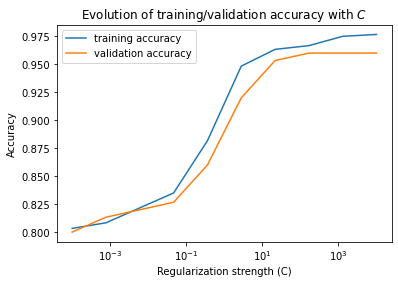

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot training/validation accuracy curves
plt.semilogx(cv_results["param_logreg__C"], cv_results["mean_train_score"], label='training accuracy')
plt.semilogx(cv_results["param_logreg__C"], cv_results["mean_test_score"],  label='validation accuracy')
plt.xlabel('Regularization strength (C)')
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with $C$")
plt.legend()
plt.show()


It seems that regularization isn’t helpful in our case. Our logistic regression model isn’t overfitting and adding regularization hurts performance i.e. underfitting.

*Making Predictions*

The GridSearchCV object has a refit parameter which is set to True by default - it automatically refits the best estimator to the entire train data and saves it in a best_estimator_ attribute.

In [54]:
# Compute predictions with the "best_estimator_" attribute
grid_cv.best_estimator_.predict(X)

# Or with the grid search object directly
grid_cv.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

*LogisticRegressionCV object*

LogisticRegressionCV let’s us define a list of C values to tune with cross-validated grid search

In [55]:
from sklearn.linear_model import LogisticRegressionCV

# Create estimator
logreg_cv = LogisticRegressionCV(
    Cs=[0.1, 1, 10], cv=5, multi_class="ovr", solver="liblinear"
)

Estimators with built-in cross-validation are usually more efficient than the generic GridSearchCV object. However, they don’t integrate with pipelines. More specifically, we cannot pass a set of preprocessing steps to apply to each training fold. Instead, we have to preprocess the data globally before the estimator

In [56]:
from sklearn.preprocessing import scale

# Fit the estimator
logreg_cv.fit(scale(X), y)

LogisticRegressionCV(Cs=[0.1, 1, 10], cv=5, multi_class='ovr',
                     solver='liblinear')

In this case, we standardize the entire input data which implies that we used data from the validation folds which isn’t optimal i.e. compute standardization mean/std on all data.

Due to the One-versus-Rest (OvR) strategy, it has one entry per class. For instance, let’s print the cross-validated results from our “class 1” vs “classes 2, 3” classifier

In [57]:
# Scores for class 1 (Setosa)
logreg_cv.scores_[0]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [58]:
# Scores for class 2 (Versicolor)
logreg_cv.scores_[1]

array([[0.66666667, 0.66666667, 0.63333333],
       [0.7       , 0.7       , 0.7       ],
       [0.66666667, 0.76666667, 0.73333333],
       [0.8       , 0.76666667, 0.76666667],
       [0.73333333, 0.76666667, 0.76666667]])

In [59]:
# Mean score per C value across folds
logreg_cv.scores_[1].mean(axis=0)

array([0.71333333, 0.73333333, 0.72      ])

Hence, the LogisticRegressionCV object will use the second C value C=1 for the virginica class. We can verify this by printing the C values for the three classes

In [60]:
print(logreg_cv.C_)

[ 0.1  1.  10. ]
